In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, stats
import calendar
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, \
                            precision_recall_curve, auc, matthews_corrcoef, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Housekeeping
import warnings
warnings.filterwarnings('ignore')

# Set default font size for various text elements
plt.rcParams['axes.titlesize'] = 35  # Title font size
plt.rcParams['axes.labelsize'] = 25  # Axes label font size
plt.rcParams['xtick.labelsize'] = 20  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 20  # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 20  # Legend font size

# Set font family and color configurations
plt.rcParams['font.family']= 'Times New Roman'
plt.rcParams['axes.facecolor'] = 'black'  
plt.rcParams['figure.facecolor'] = 'black' 
plt.rcParams['text.color'] = 'white'  
plt.rcParams['axes.labelcolor'] = 'white' 
plt.rcParams['xtick.color'] = 'white'  
plt.rcParams['ytick.color'] = 'white'  
plt.rcParams['axes.edgecolor'] = 'white'

# Set seaborn style
seaborn_style = {
    "font.family": "Times New Roman",
    "axes.facecolor": "black",
    "figure.facecolor": "black",
    "text.color": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "axes.edgecolor": "white"
}
sns.set_style("dark", seaborn_style)

In [2]:
data = pd.read_csv('bank.csv')
df = pd.DataFrame(data)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


None

In [3]:
display(df.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


# 1. Customer Profiling

General demographic info

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


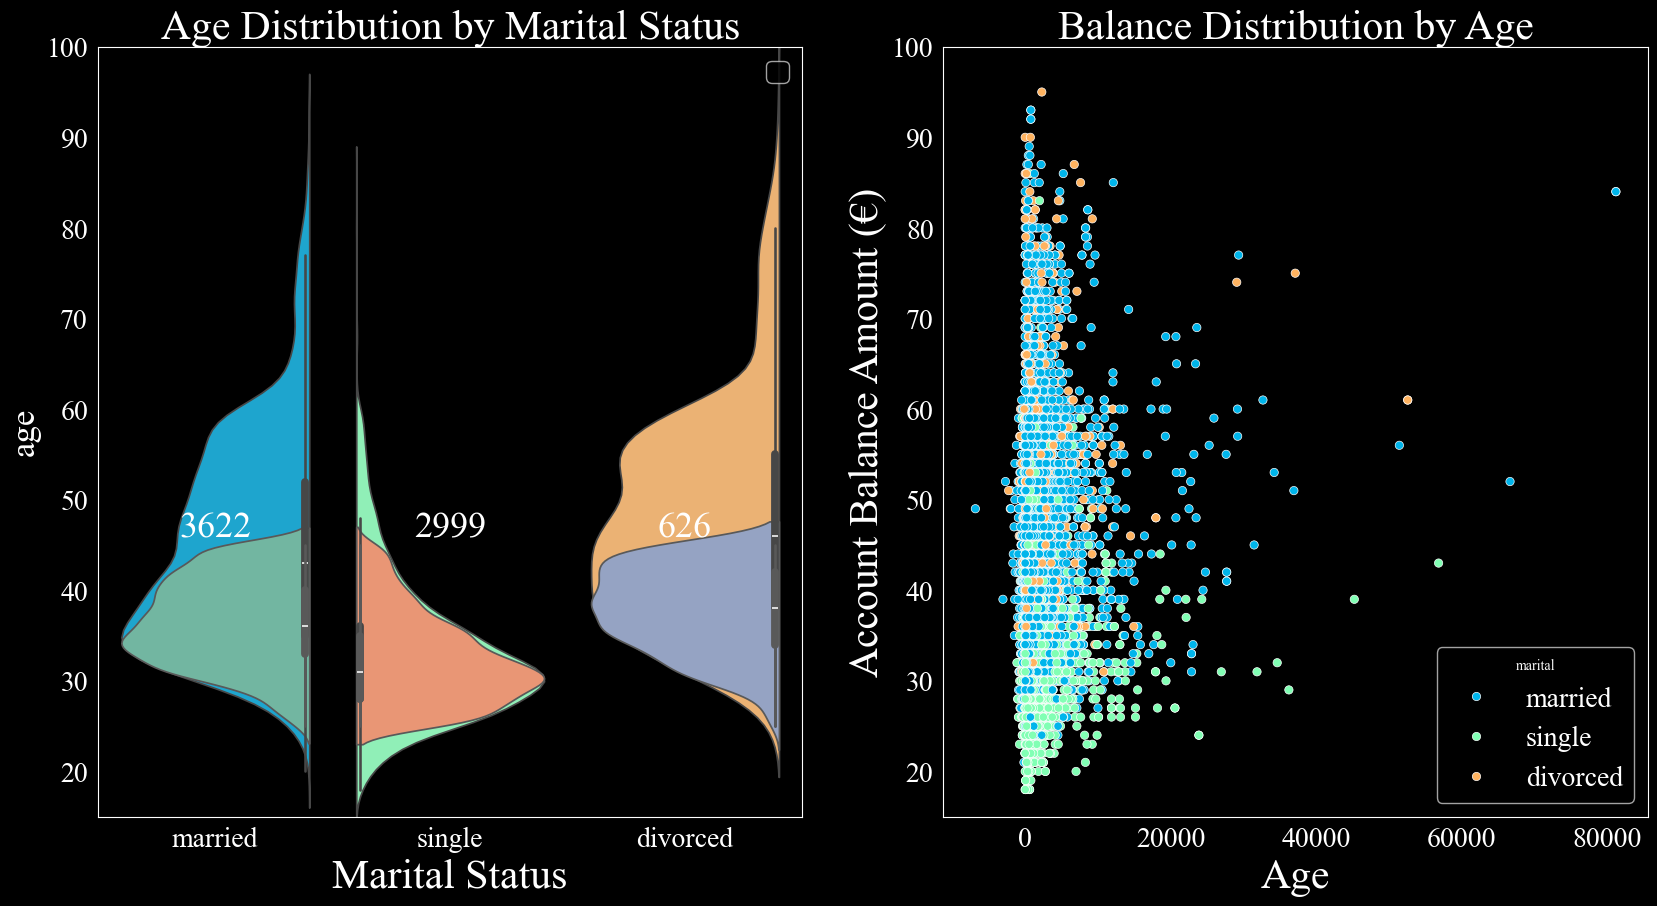

In [4]:
# sns.set_style('whitegrid')

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
# Ploting 1: age distribution by marital status
ax1 = sns.violinplot(x='marital', y='age', data=df, palette='rainbow', split=True, ax=ax1)
highlight = df[(df['age'] >= 25) & (df['age'] <= 45)]
highlight_count = highlight['marital'].value_counts()
ax1 = sns.violinplot(x='marital', y='age', data=highlight, palette='Set2', split=True, ax=ax1)
ax1.set_title('Age Distribution by Marital Status', fontsize=30)
ax1.set_xlabel('Marital Status', fontsize=30)
ax1.set_ylim(15, 100)
for i, marital_status in enumerate(df['marital'].unique()):
    ax1.text(i, 45, s=f'{highlight_count[marital_status]}', ha='center', va='bottom', fontsize=26, color='white')
ax1.legend()
# Plot 2: Balance distribution by age
ax2 = sns.scatterplot(x='balance', y='age', data=df, hue='marital', palette='rainbow', ax=ax2)
average_balances = df.groupby('marital')['balance'].mean().sort_values(ascending=False)
# for i, (marital_status, avg_balance) in enumerate(average_balances.items()):
    # Annotate the average balance line with the marital status and value
    # ax2.text(df['age'].max(), avg_balance, f'{marital_status} Avg: {avg_balance:.0f}', 
    #          horizontalalignment='right', verticalalignment='center', 
    #          fontsize=15, color=sns.color_palette("Set2")[i])

ax2.set_title('Balance Distribution by Age', fontsize=30)
ax2.set_xlabel('Age', fontsize=30)
ax2.set_ylim(15, 100)
ax2.set_ylabel('Account Balance Amount (€)', fontsize=30)


plt.show()

In [5]:
print(average_balances)

marital
married     1599.927570
single      1457.255259
divorced    1371.835267
Name: balance, dtype: float64


Detailed fianancial health analysis by job

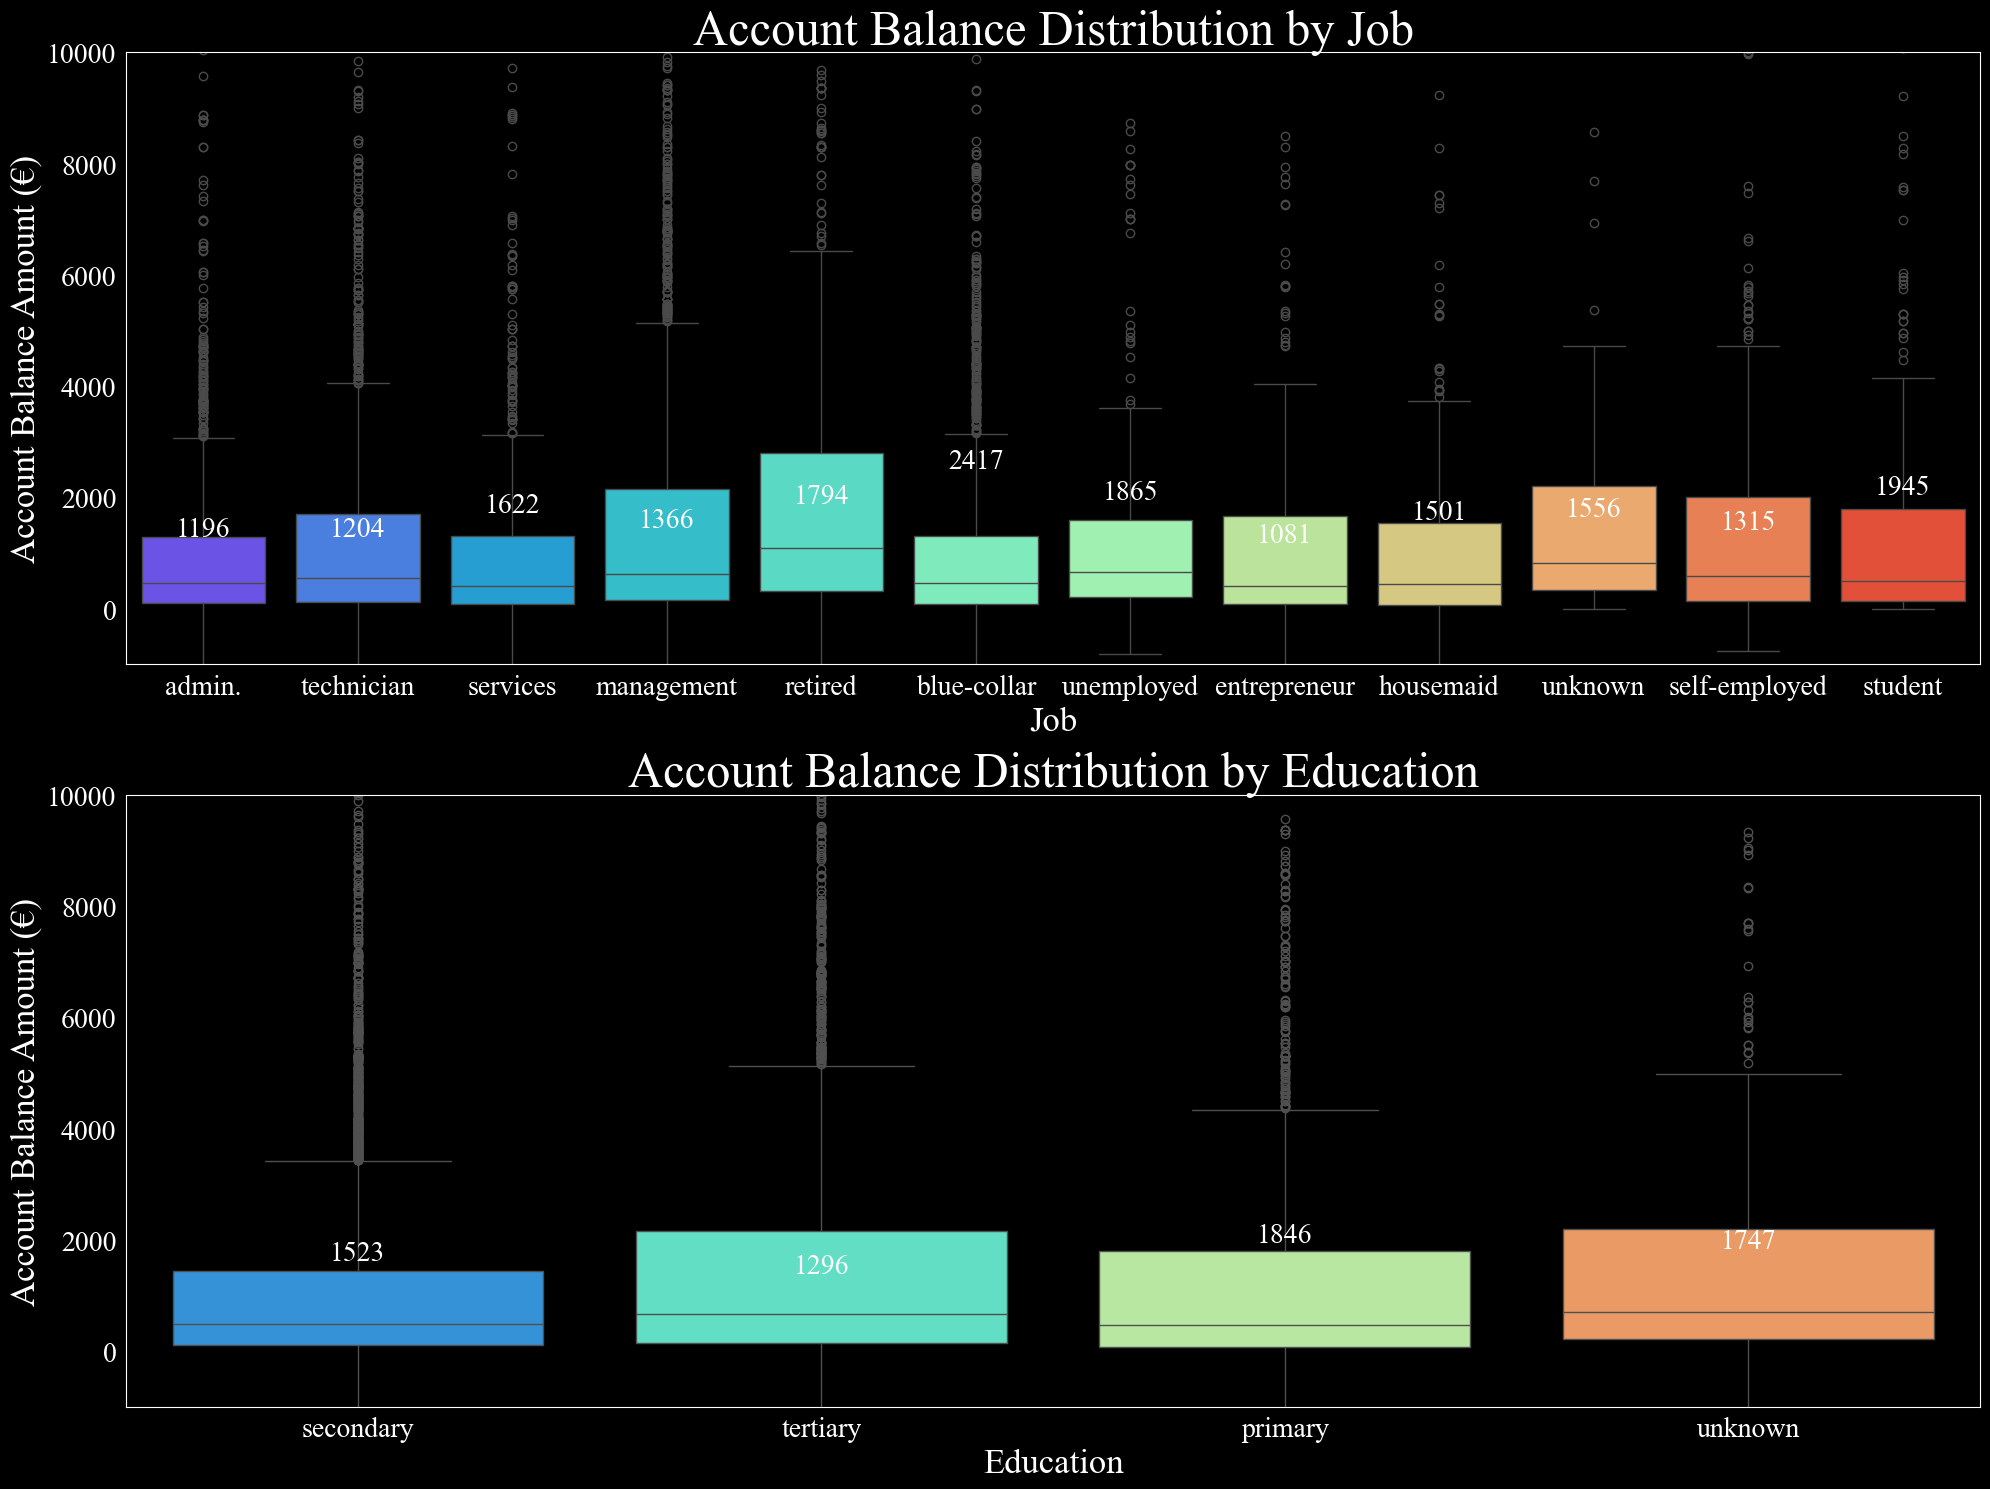

In [33]:
job_mean_balance = df.groupby('job')['balance'].mean().reset_index()

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(20, 15))
# Plot 1: Balance distribution by job
ax1 = sns.boxplot(x='job', y='balance', data=df, palette='rainbow', ax=ax1)
for i, (job, mean_balance) in enumerate(job_mean_balance.values.tolist()):
    ax1.text(i, mean_balance, f'{mean_balance:.0f}', ha='center', fontsize=20, va='bottom',color='white')
ax1.set_title('Account Balance Distribution by Job')
ax1.set_xlabel('Job')
ax1.set_ylim(-1000, 10000)
ax1.set_ylabel('Account Balance Amount (€)')

# Plot 2: Balance distribution by education
education_mean_balance = df.groupby('education')['balance'].mean().reset_index()

ax2 = sns.boxplot(x='education', y='balance', data=df, palette='rainbow', ax=ax2)
for i, (education, mean_balance) in enumerate(education_mean_balance.values.tolist()):
    ax2.text(i, mean_balance, f'{mean_balance:.0f}', ha='center',fontsize=20, va='bottom', color='white')
ax2.set_title('Account Balance Distribution by Education')
ax2.set_xlabel('Education')
ax2.set_ylim(-1000, 10000)
ax2.set_ylabel('Account Balance Amount (€)')
plt.tight_layout()
plt.show()


### Hypothesis 1.1: Customers with loans are less likely to opt for term deposit

deposit    no   yes
loan               
no       4897  4805
yes       976   484
Chi2: 135.83
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between those with loan and those without loan


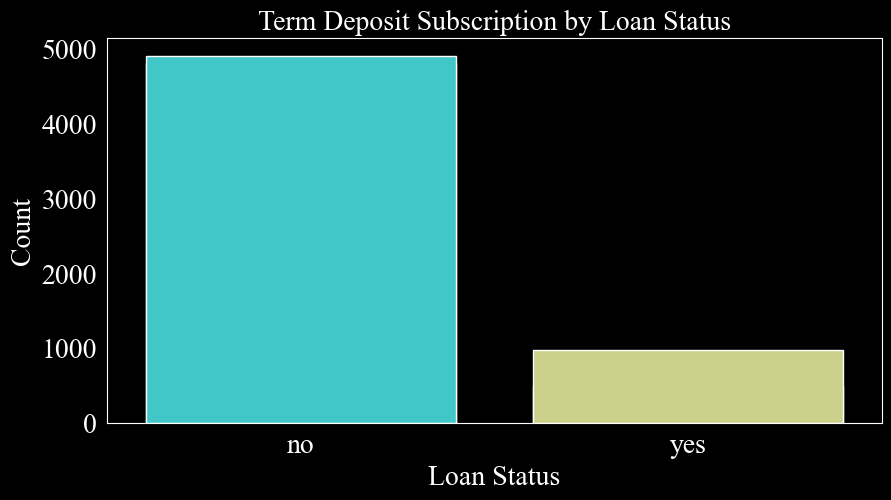

In [7]:
contigency_table = pd.crosstab(df['loan'], df['deposit']) 
print(contigency_table)
chi2, p, dof, expected = chi2_contingency(contigency_table)

plt.figure(figsize=(10, 5))
sns.barplot(x=contigency_table.index, y=contigency_table['yes'], palette='rainbow', label='Yes')
sns.barplot(x=contigency_table.index, y=contigency_table['no'], palette='rainbow', label='No')
plt.title('Term Deposit Subscription by Loan Status', fontsize=20)
plt.xlabel('Loan Status', fontsize=20)
plt.ylabel('Count', fontsize=20)

print(f'Chi2: {chi2:.2f}')
print(f'p-value: {p:.2f}')

alpha = 0.05
if p <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between those with loan and those without loan')
else:
    print('Fail to reject H0')

### Hypothesis 1.2: Lower account balances correlate with lower likelihood of accepting term deposit


Pearson Correlation table

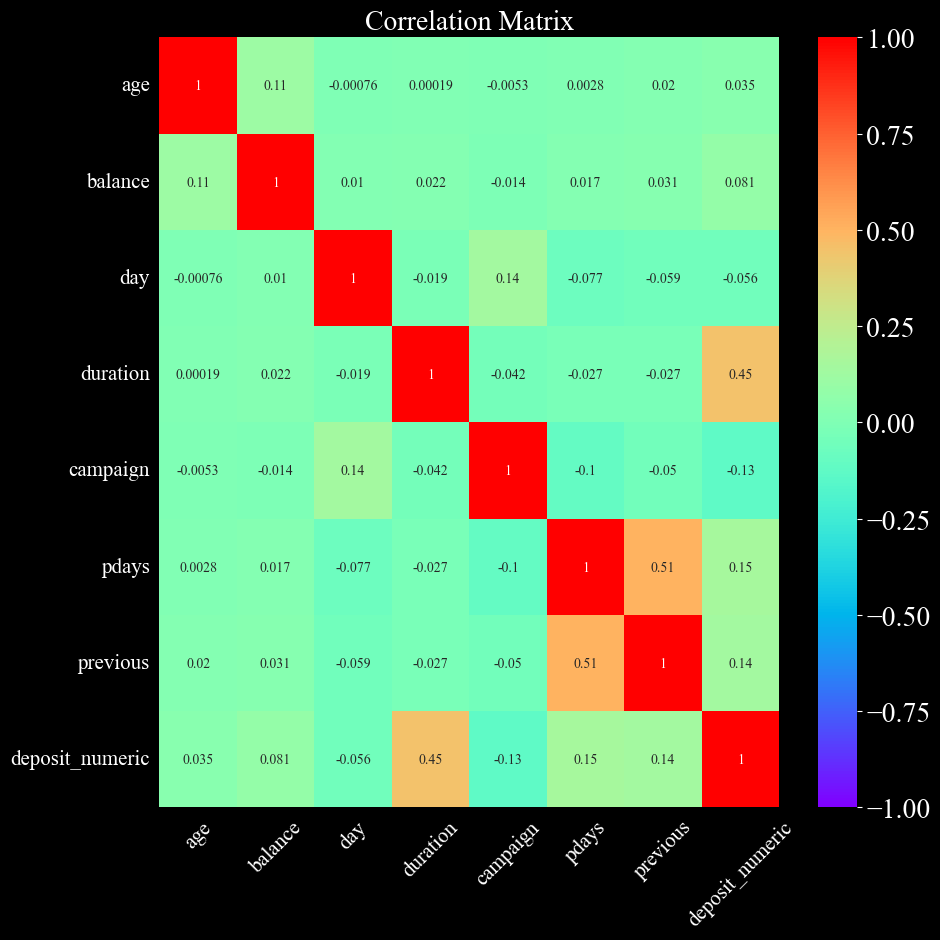

In [8]:
df['deposit_numeric'] = df['deposit'].map({'yes': 1, 'no': 0})

num_df = df[df.select_dtypes(include=np.number).columns]
corr_matrix = num_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='rainbow', vmin=-1, vmax=1)

plt.title('Correlation Matrix', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=0,fontsize=15)

plt.show()

Hypothesis testing

In [9]:
print(f'Correlation between account balance and term deposit subscription: {corr_matrix.loc["balance", "deposit_numeric"]:.2f}')
print('Reject hypothesis due to low correlations')

Correlation between account balance and term deposit subscription: 0.08
Reject hypothesis due to low correlations


### Hypothesis 1.3: Younger clients are less likely to enroll to term deposit

# 2. Telemarketing Strategy


### Hypothesis 2.1: Deposit subscription has seasonality

Monthly seasonality

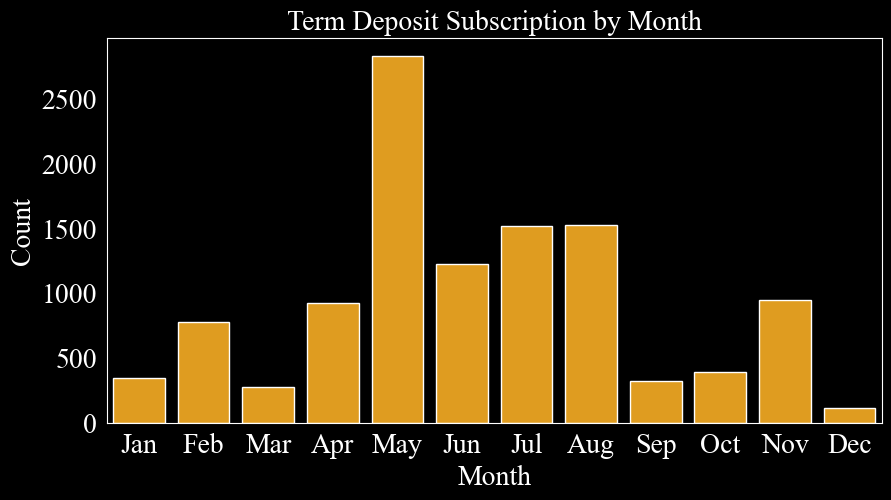

In [10]:
month_order = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# new column with month number
df['month_num'] = df['month'].apply(lambda x: month_order[x.strip().lower()])

# group by month_num and count and average the number of subscriptions
monthly_stats = df.groupby('month_num').agg({'deposit' : ['count']}).reset_index()
monthly_stats.columns = ['month_num', 'deposit_count']

# sort by numerical month
monthly_stats.sort_values(by='month_num', inplace=True)

# Plot
month_names = [calendar.month_abbr[i] for i in monthly_stats['month_num']]
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1 = sns.barplot(x='month_num', y='deposit_count', data=monthly_stats, color='orange')

ax1.set_title('Term Deposit Subscription by Month', fontsize=20)
ax1.set_xticklabels(month_names)
ax1.set_xlabel('Month', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)

plt.show()


In [11]:
# Test seasonality hypothesis - ANOVA
f_value, p_value = stats.f_oneway(*[df[df['month'] == month]['deposit_numeric'] for month in df['month'].unique()])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value:.2f}')

alpha = 0.05
if p_value <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between months')
else:
    print('Fail to reject H0')

F-value: 104.90
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between months


Day of the month seasonality

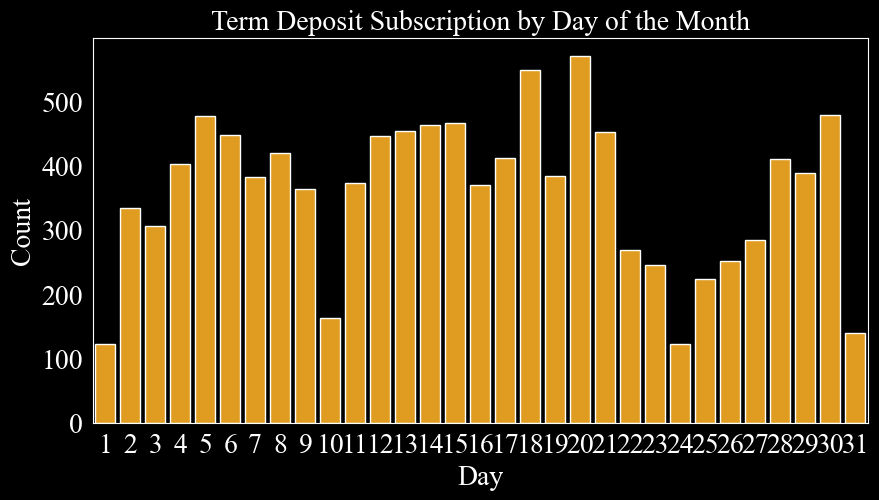

F-value: 12.50
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month


In [12]:
# group by day and count and average the number of subscriptions
daily_stats = df.groupby('day')['deposit_numeric'].agg(['count']).reset_index()
daily_stats.columns = ['day', 'deposit_count']

# sort by day of the month
daily_stats.sort_values(by='day', inplace=True)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1 = sns.barplot(x='day', y='deposit_count', data=daily_stats, color='orange')

ax1.set_title('Term Deposit Subscription by Day of the Month', fontsize=20)
ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)

plt.show()# Test seasonality hypothesis - ANOVA
f_value, p_value = stats.f_oneway(*[df[df['day'] == day]['deposit_numeric'] for day in sorted(df['day'].unique())])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value:.2f}')

alpha = 0.05
if p_value <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month')
else:
    print('Fail to reject H0')

In [13]:
# Test seasonality hypothesis - ANOVA
f_value, p_value = stats.f_oneway(*[df[df['day'] == day]['deposit_numeric'] for day in sorted(df['day'].unique())])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value:.2f}')

alpha = 0.05
if p_value <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month')
else:
    print('Fail to reject H0')

F-value: 12.50
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between day of the Month


### Hypothesis 2.2: The optimal duration of a call

Distribution

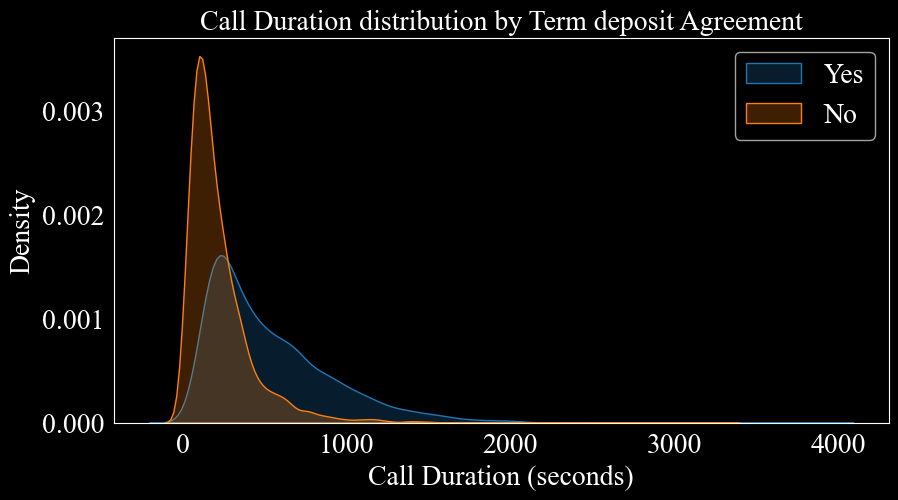

In [14]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['deposit'] == 'yes']['duration'], shade=True, label='Yes')
sns.kdeplot(df[df['deposit'] == 'no']['duration'], shade=True, label='No')
plt.title('Call Duration distribution by Term deposit Agreement', fontsize=20)
plt.xlabel('Call Duration (seconds)', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend()
plt.show()

Prediction Model

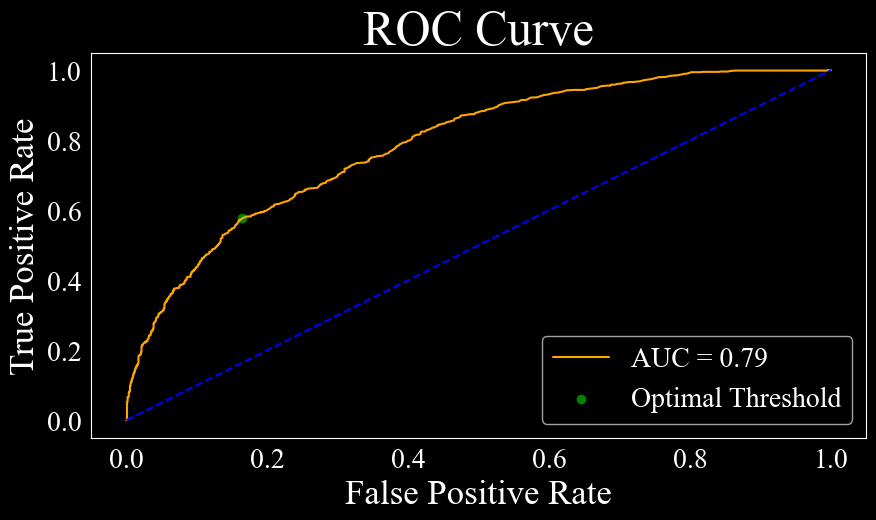

In [15]:
# set up data and model
X_train, X_test, y_train, y_test = train_test_split(df['duration'].values.reshape(-1, 1), df['deposit_numeric'],
                                                    test_size=0.2, random_state=42)
duration_model = LogisticRegression()
duration_model.fit(X_train, y_train)

y_prob = duration_model.predict_proba(X_test)[:, 1]

# calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_score = roc_auc_score(y_test, y_prob)

# optimal 
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='orange', label=f'AUC = {roc_auc_score:.2f}')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='green', label='Optimal Threshold')
plt.plot([0,1], [0,1], color='blue', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Dimishing Return point

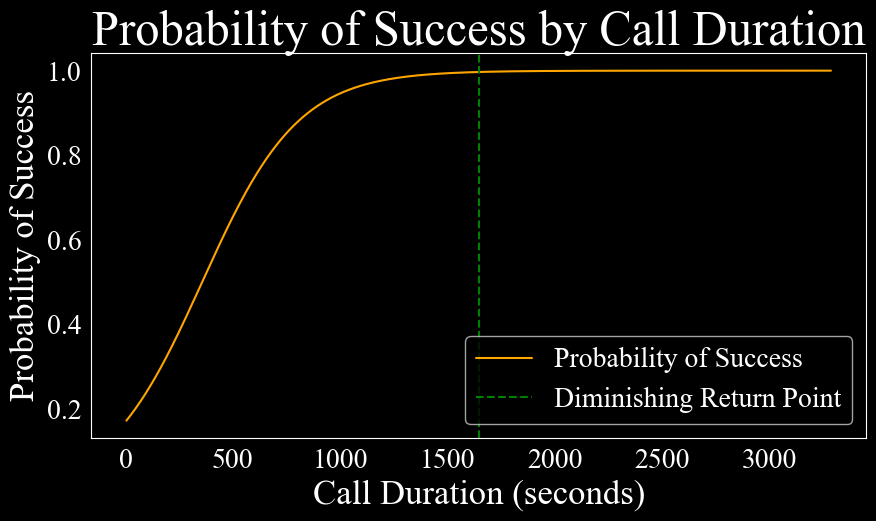

In [16]:
X_test_new = np.linspace(X_test.min(), X_test.max(), 1000).reshape(-1,1)
y_prob_new = duration_model.predict_proba(X_test_new)[:, -1]

# Find diminishing return point - bottom 50% of rate of change
rate_of_change = np.diff(y_prob_new) / np.diff(X_test_new.flatten())
diminishing_return_point = X_test_new[np.argmax(rate_of_change < np.percentile(rate_of_change, 50))][0]

# Plot probability distribution
plt.figure(figsize=(10, 5))
plt.plot(X_test_new, y_prob_new, color='orange', label='Probability of Success')
plt.axvline(diminishing_return_point, color='green', linestyle='--', label='Diminishing Return Point')
plt.title('Probability of Success by Call Duration')
plt.xlabel('Call Duration (seconds)')
plt.ylabel('Probability of Success')
plt.legend()
plt.show()

In [17]:
print(f'Base on the LogisticalRegression model, the diminishing return point is at {diminishing_return_point:.0f} seconds')

Base on the LogisticalRegression model, the diminishing return point is at 1646 seconds


F1-score: 0.6579085654230162


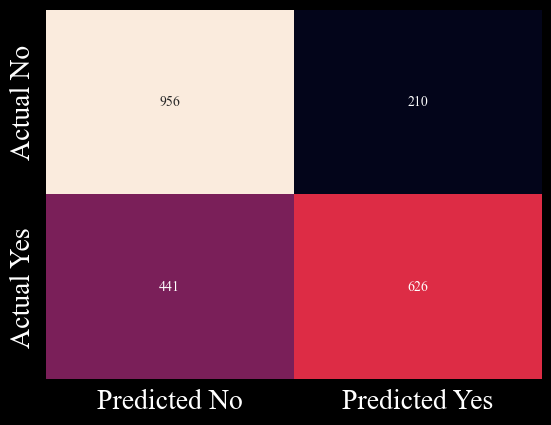

In [18]:
# f1-score
y_pred = duration_model.predict(X_test)
print(f"F1-score: {f1_score(y_test, y_pred)}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
plt.show()

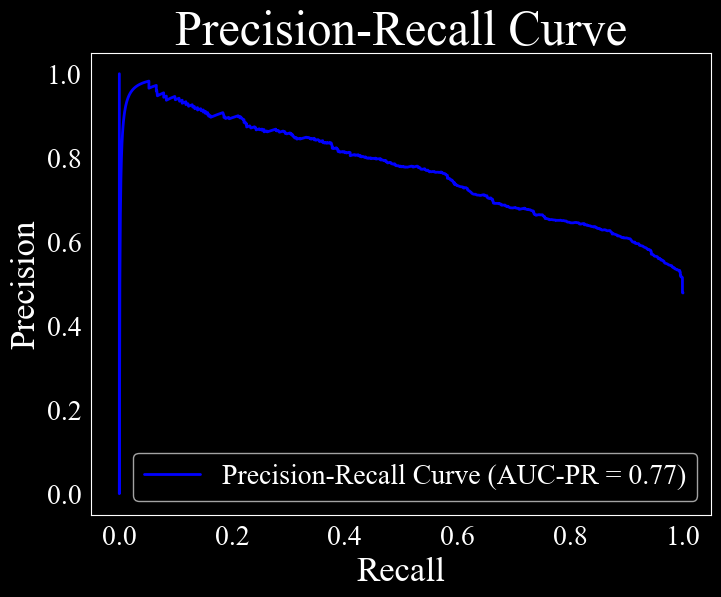

In [19]:
# Area Under the Precision-Recall Curve (AUC-PR)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_pr = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve (AUC-PR = {:.2f})'.format(auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

Interpretation of MCC values:
- 1: Perfect prediction
- 0: Random prediction
- -1: Total disagreement between predictions and actual outcomes

In [20]:
# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc}")

Matthews Correlation Coefficient (MCC): 0.41964832446540096


### Hypothesis 2.3: There is a needed break between two campaigns

Distribution

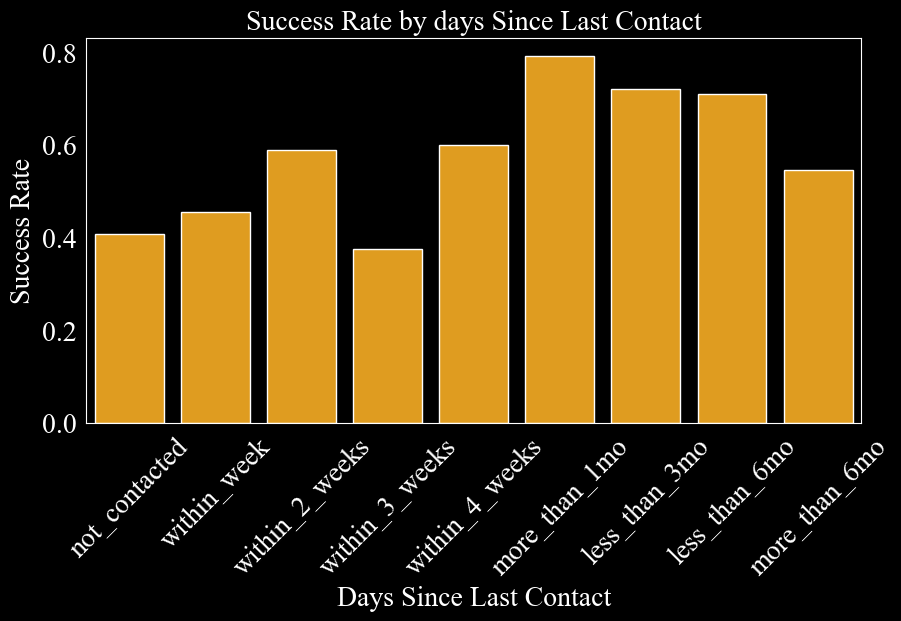

In [21]:
# Define cat for pday - time since last contact in days
bins = [-1, 0, 7, 14, 21, 28, 90, 180, 270, 999]
labels = ['not_contacted','within_week', 'within_2_weeks', 'within_3_weeks', 'within_4_weeks',
          'more_than_1mo', 'less_than_3mo', 'less_than_6mo', 'more_than_6mo']
df['pday_cat'] = pd.cut(df['pdays'], bins=bins, labels=labels, right=False)

# Success rate by pday cat
success_rate = df.groupby('pday_cat')['deposit_numeric'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x='pday_cat', y='deposit_numeric', data=success_rate, color='orange')
plt.title('Success Rate by days Since Last Contact', fontsize=20)
plt.xlabel('Days Since Last Contact', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Success Rate', fontsize=20)
plt.show()

Statistical test

In [22]:
# Contingency table
contingency_table = pd.crosstab(df['pday_cat'], df['deposit'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(contingency_table)
print(f'Chi-squared: {chi2:.2f}')
print(f'p-value: {p:.2f}')

if p <= alpha:
    print('Reject H0: There is significant difference in the proportion of customer opting for term deposits between days since last contact')
else:
    print('Fail to reject H0')


deposit           no   yes
pday_cat                  
not_contacted   4940  3384
within_week       12    10
within_2_weeks     7    10
within_3_weeks     5     3
within_4_weeks     2     3
more_than_1mo     51   194
less_than_3mo    269   694
less_than_6mo    229   561
more_than_6mo    358   430
Chi-squared: 680.71
p-value: 0.00
Reject H0: There is significant difference in the proportion of customer opting for term deposits between days since last contact


Learning Model

In [23]:
# data
X_train, X_test, y_train, y_test = train_test_split(df[['pdays']], 
                                                    df['deposit_numeric'], test_size=0.2, random_state=42)
last_contact_model = LogisticRegression()
last_contact_model.fit(X_train, y_train)

# # Predict probabilities
# y_prob_new = last_contact_model.predict_proba(X_test)[:, 1]
# auc = roc_auc_score(y_test, y_prob_new)
# print(f'AUC: {auc:.2f}')

# Predict
y_pred = last_contact_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.84      0.69      1166
           1       0.67      0.35      0.46      1067

    accuracy                           0.61      2233
   macro avg       0.63      0.60      0.58      2233
weighted avg       0.62      0.61      0.58      2233



## 3. Predictive Analysis

Optimal input features and machine learning model that give the best prediction of customer agreeing to term deposit

In [24]:
X = df.drop(columns=['deposit', 'deposit_numeric','pday_cat'])
label_encoder = LabelEncoder()

# Iterate over categorical columns and encode them
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])
y = df['deposit_numeric']

rf = RandomForestClassifier(random_state=42)

# cross validation
cv_score = cross_val_score(rf, X, y, cv=10, scoring='roc_auc')
print(f'Average ROC-AUC score: {cv_score.mean():.2f}')

rf.fit(X, y)

# feature reduction
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, 
                                  columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

Average ROC-AUC score: 0.89
           importance
duration     0.361946
balance      0.080601
age          0.076657
day          0.074392
month_num    0.063236
month        0.054458
pdays        0.045334
contact      0.039587
job          0.036273
poutcome     0.033628
housing      0.031736
campaign     0.031256
previous     0.021776
education    0.021563
marital      0.016682
loan         0.009513
default      0.001361


In [25]:
# grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X, y)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_:2f}')

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best score: 0.896666
